In [1]:
# import flowformer元件
from ast import List, Tuple
import sys

from sympy import root
sys.path.append('core')

from PIL import Image
from glob import glob
import argparse
import os
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim
import matplotlib.pyplot as plt
from configs.submission import get_cfg
from core.utils.misc import process_cfg
import core.datasets
from core.utils import flow_viz
from core.utils import frame_utils
import cv2
import math
import os.path as osp
from pathlib import Path
from tqdm import tqdm

from core.FlowFormer import build_flowformer

from core.utils.utils import InputPadder, forward_interpolate
import itertools

import flow_compute
import torch.utils.data as data

TRAIN_SIZE = [432, 960]
plt.rcParams['font.sans-serif'] = ['DFKai-SB']
plt.rcParams['axes.unicode_minus'] = False

building  model...


## 讀取深度

In [2]:
def depth_read(filename) -> torch.float64:
    # loads depth map D from png file
    # and returns it as a numpy array,
    # for details see readme.txt

    depth_png = np.array(Image.open(filename), dtype=int)
    # make sure we have a proper 16bit depth map here.. not 8bit!
    assert (np.max(depth_png) > 255)

    depth = depth_png.astype(float) / 256.
    depth[depth_png == 0] = -1.
    return torch.from_numpy(depth)

### 測試讀取一項

In [3]:
depth = depth_read(
    r"E:\datasets\KITTI_Depth Prediction\data_depth_annotated\train\2011_09_26_drive_0001_sync\proj_depth\groundtruth\image_02\0000000005.png")
print(torch.max(depth))
print(torch.min(depth))

tensor(84.8945, dtype=torch.float64)
tensor(-1., dtype=torch.float64)


### 讀取所有深度並且plt出最小及最大值

100%|██████████| 42949/42949 [17:20<00:00, 41.26it/s]


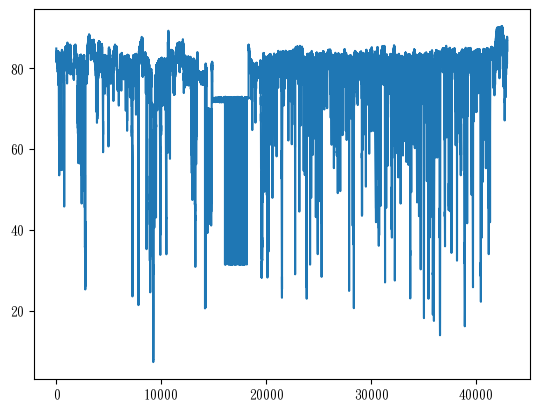

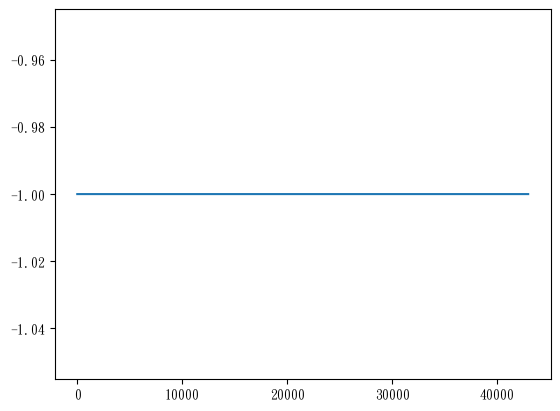

In [6]:
depth_paths = r'E:\datasets\KITTI_Depth Prediction\data_depth_annotated\train'
depth_paths = Path(depth_paths)

depth_paths = depth_paths.iterdir()
path_depth_02s = []
path_depth_03s = []
for path in depth_paths:
    # 取得深度影像
    path_depth_02s+=sorted((path / "proj_depth" / 'groundtruth' / "image_02").glob("*.png"))
    path_depth_03s+=sorted((path / "proj_depth" / 'groundtruth' / "image_03").glob("*.png"))

path_depth_02_mins = []
path_depth_02_maxs = []
path_depth_03_mins = []
path_depth_03_maxs = []
for path_depth_02 in tqdm(path_depth_02s):
    depth = depth_read(path_depth_02)
    path_depth_02_mins.append(torch.min(depth))
    path_depth_02_maxs.append(torch.max(depth))

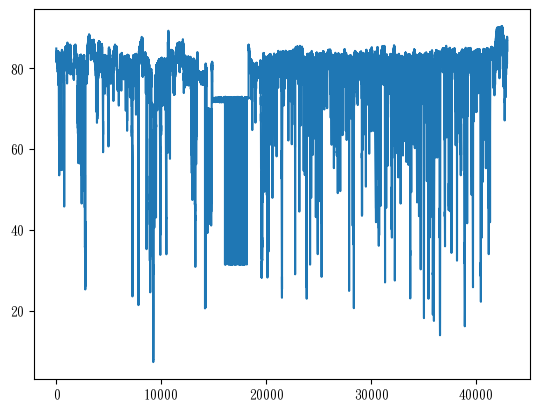

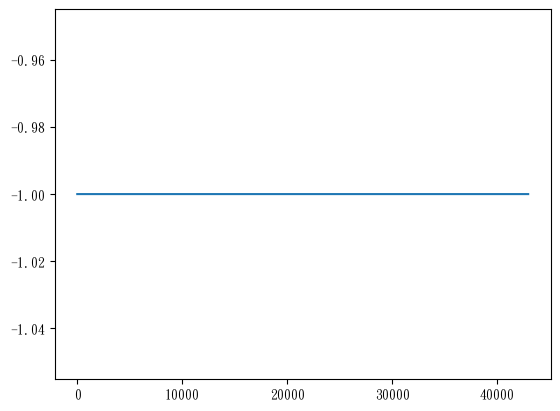

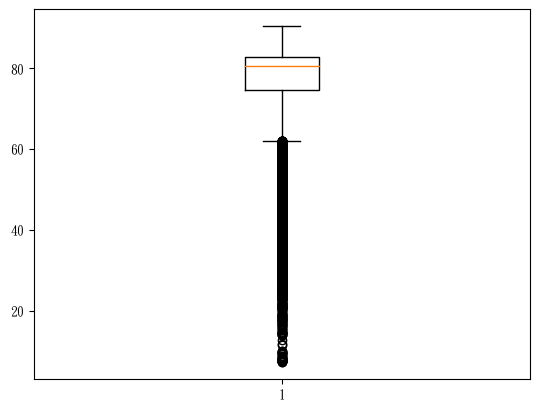

In [62]:
plt.plot(path_depth_02_mins)
plt.show()
plt.plot(path_depth_02_maxs)
plt.show()
plt.boxplot(path_depth_02_mins)
plt.show()

In [12]:
print(f"最大深度的最小值: {min(path_depth_02_mins)}")
print(f"最大深度的最大值: {max(path_depth_02_mins)}")

最大深度的最小值: 7.28125
最大深度的最大值: 90.44140625


## 預測深度

In [14]:
def get_KITTI_Q_matrix(date: str) -> np.ndarray:
    KITTI_path = Path(
        r'E:\datasets\KITTI')
    calib_path = KITTI_path / date / "calib_cam_to_cam.txt"
    calib = calib_path.read_text()
    # with calib_path.open('r') as f:
    #     calib = f.readlines()
    calib = calib.split('\n')
    # print(len(calib))
    # print(calib)

    K_02 = np.array(calib[19].strip().split()[1:]
                    ).astype(float).reshape((3, 3))
    D_02 = np.array(calib[20].strip().split()[1:]
                    ).astype(float).flatten()
    R_02 = np.array(calib[21].strip().split()[1:]
                    ).astype(float).reshape((3, 3))
    T_02 = np.array(calib[22].strip().split()[1:]
                    ).astype(float).flatten()
    S_rect_02 = np.array(calib[23].strip().split()[
                         1:]).astype(float).flatten()
    R_rect_02 = np.array(calib[24].strip().split()[
                         1:]).astype(float).reshape((3, 3))
    P_rect_02 = np.array(calib[25].strip().split()[
                         1:]).astype(float).reshape((3, 4))
    K_03 = np.array(calib[27].strip().split()[1:]
                    ).astype(float).reshape((3, 3))
    D_03 = np.array(calib[28].strip().split()[1:]
                    ).astype(float).flatten()
    R_03 = np.array(calib[29].strip().split()[1:]
                    ).astype(float).reshape((3, 3))
    R_rect_03 = np.array(calib[32].strip().split()[
                         1:]).astype(float).reshape((3, 3))
    P_rect_03 = np.array(calib[33].strip().split(
    )[1:]).astype(float).reshape((3, 4))

    R1, R2, P1, P2, Q, RECT1, RECT2 = cv2.stereoRectify(
        K_02, D_02, K_03, D_03, S_rect_02.astype(int), R_02, T_02, R_03)
    # P_rect_02_err = sum(abs(P1.flatten() - P_rect_02.flatten())) / 12
    # P_rect_03_err = sum(abs(P2.flatten() - P_rect_03.flatten())) / 12
    return Q

In [20]:
predict_flow=torch.load(r"E:\ck\master\ff_depth\flow_pre_compute\2011_09_26_drive_0001_sync\0000000005.pt")
disparityimg = np.squeeze(np.delete(np.array(predict_flow), 1, axis=2))
_3d_map = cv2.reprojectImageTo3D(disparityimg, get_KITTI_Q_matrix("2011_09_26"))
predict_depth = torch.from_numpy(_3d_map[:, :, 2])
print(predict_depth.shape)

torch.Size([375, 1242])


## 計算LOSS

In [42]:
def count_SILog(pr:torch.tensor,gt:torch.tensor)->float:
    if pr.shape!=gt.shape:
        return
    pr=torch.flatten(pr)
    gt=torch.flatten(gt)
    pr = pr[gt != -1]
    gt = gt[gt != -1]
    sum=0
    sum_square=0
    n=len(gt)
    for p,g in zip(pr,gt):
        di=math.log2(g)-math.log2(p)
        sum+=di
        sum_square+=di*di
    
    return ((1/n)*sum_square)-((1/(n*n))*(sum*sum))

In [51]:
# copy from https://github.com/ShuweiShao/NDDepth/blob/main/Estimation/nddepth_kittiofficial/utils.py
# 我看train.py中是使用這個
def compute_errors_kb(gt, pred):
    thresh = np.maximum((gt / pred), (pred / gt))
    d1 = (thresh < 1.25).mean()
    d2 = (thresh < 1.25 ** 2).mean()
    d3 = (thresh < 1.25 ** 3).mean()

    gt_inv = 1.0 / (1e-3 * gt + 1e-8)
    pred_inv = 1.0 / (1e-3 * pred + 1e-8)

    rms = (gt - pred) ** 2
    rms = np.sqrt(rms.mean())

    irms = (gt_inv - pred_inv) ** 2
    irms = np.sqrt(irms.mean())

    log_rms = (np.log(gt) - np.log(pred)) ** 2
    log_rms = np.sqrt(log_rms.mean())

    abs_rel = np.mean(np.abs(gt - pred) / gt) * 100
    sq_rel = np.mean(((gt - pred) / gt) ** 2) * 100

    err = np.log(pred) - np.log(gt)
    silog = np.sqrt(np.mean(err ** 2) - np.mean(err) ** 2) * 100

    err = np.abs(np.log10(pred) - np.log10(gt))
    log10 = np.mean(err)

    return [silog, abs_rel, log10, rms, irms, sq_rel, log_rms, d1, d2, d3]

In [59]:
def compute_errors(gt, pred):
    thresh = np.maximum((gt / pred), (pred / gt))
    d1 = (thresh < 1.25).mean()
    d2 = (thresh < 1.25 ** 2).mean()
    d3 = (thresh < 1.25 ** 3).mean()

    rms = (gt - pred) ** 2
    rms = np.sqrt(rms.mean())

    log_rms = (np.log(gt) - np.log(pred)) ** 2
    log_rms = np.sqrt(log_rms.mean())

    abs_rel = np.mean(np.abs(gt - pred) / gt)
    sq_rel = np.mean(((gt - pred) ** 2) / gt)

    err = np.log(pred) - np.log(gt)
    silog = np.sqrt(np.mean(err ** 2) - np.mean(err) ** 2) * 100

    err = np.abs(np.log10(pred) - np.log10(gt))
    log10 = np.mean(err)

    return [silog, abs_rel, log10, rms, sq_rel, log_rms, d1, d2, d3]

In [40]:
depth = depth_read(
    r"E:\datasets\KITTI_Depth Prediction\data_depth_annotated\train\2011_09_26_drive_0001_sync\proj_depth\groundtruth\image_02\0000000005.png")
print(depth.shape)
print(predict_depth.shape)

torch.Size([375, 1242])
torch.Size([375, 1242])


In [57]:
count_SILog(predict_depth, depth)

0.0035402066397747234

In [58]:
# 總之先決定用這個當loss
silog, abs_rel, log10, rms, irms, sq_rel, log_rms, d1, d2, d3 = compute_errors_kb(
    np.array(depth), np.array(predict_depth))
print(f"silog: {silog}\nabs_rel: {abs_rel}\nlog10: {log10}\nrms: {rms}\nirms: {irms}\nsq_rel: {sq_rel}\nlog_rms: {log_rms}\nd1: {d1}\nd2: {d2}\nd3: {d3}")

silog: nan
abs_rel: -471.5071350959571
log10: nan
rms: 14.4220452820279
irms: 1331.298166863759
sq_rel: 14126.297812353732
log_rms: nan
d1: 0.8049618894256575
d2: 0.8049618894256575
d3: 0.8049618894256575


C:\Users\ck\AppData\Local\Temp\ipykernel_11980\1273458925.py:16: RuntimeWarning: invalid value encountered in log
  log_rms = (np.log(gt) - np.log(pred)) ** 2
C:\Users\ck\AppData\Local\Temp\ipykernel_11980\1273458925.py:22: RuntimeWarning: invalid value encountered in log
  err = np.log(pred) - np.log(gt)
C:\Users\ck\AppData\Local\Temp\ipykernel_11980\1273458925.py:25: RuntimeWarning: invalid value encountered in log10
  err = np.abs(np.log10(pred) - np.log10(gt))


In [61]:
silog, abs_rel, log10, rms, sq_rel, log_rms, d1, d2, d3 = compute_errors(
    np.array(depth), np.array(predict_depth))
print(f" silog: {silog}\n abs_rel: {abs_rel}\n log10: {log10}\n rms: {rms}\n sq_rel: {sq_rel}\n log_rms: {log_rms}\n d1: {d1}\n d2: {d2}\n d3: {d3}")

 silog: nan
 abs_rel: -4.715071350959571
 log10: nan
 rms: 14.4220452820279
 sq_rel: -138.59314132996028
 log_rms: nan
 d1: 0.8049618894256575
 d2: 0.8049618894256575
 d3: 0.8049618894256575


C:\Users\ck\AppData\Local\Temp\ipykernel_11980\404497467.py:10: RuntimeWarning: invalid value encountered in log
  log_rms = (np.log(gt) - np.log(pred)) ** 2
C:\Users\ck\AppData\Local\Temp\ipykernel_11980\404497467.py:16: RuntimeWarning: invalid value encountered in log
  err = np.log(pred) - np.log(gt)
C:\Users\ck\AppData\Local\Temp\ipykernel_11980\404497467.py:19: RuntimeWarning: invalid value encountered in log10
  err = np.abs(np.log10(pred) - np.log10(gt))


## 使用現有cv2.reprojectImageTo3D()取得全部loss

In [63]:
def got_loss_from_flow(flow_path):
    flow_path = Path(flow_path)
    flow = torch.load(flow_path)
    disparityimg = np.squeeze(np.delete(np.array(flow), 1, axis=2))
    _3d_map = cv2.reprojectImageTo3D(
        disparityimg, get_KITTI_Q_matrix(flow_path.parts[5][:10]))
    predict_depth = torch.from_numpy(_3d_map[:, :, 2])
    depth_path = Path(r"E:\datasets\KITTI_Depth Prediction\data_depth_annotated\train")/flow_path.parts[5]/"proj_depth"/"groundtruth"/"image_02"/(flow_path.stem+".png")
    depth = depth_read(depth_path)
    return compute_errors_kb(np.array(depth), np.array(predict_depth))

test_flow_path = r"E:\ck\master\ff_depth\flow_pre_compute\2011_09_26_drive_0001_sync\0000000005.pt"
test_depth_path = r"E:\datasets\KITTI_Depth Prediction\data_depth_annotated\train\2011_09_26_drive_0001_sync\proj_depth\groundtruth\image_02\0000000005.png"
print(got_loss_from_flow(test_flow_path))

[nan, -471.5071350959571, nan, 14.4220452820279, 1331.298166863759, 14126.297812353732, nan, 0.8049618894256575, 0.8049618894256575, 0.8049618894256575]


C:\Users\ck\AppData\Local\Temp\ipykernel_11980\1273458925.py:16: RuntimeWarning: invalid value encountered in log
  log_rms = (np.log(gt) - np.log(pred)) ** 2
C:\Users\ck\AppData\Local\Temp\ipykernel_11980\1273458925.py:22: RuntimeWarning: invalid value encountered in log
  err = np.log(pred) - np.log(gt)
C:\Users\ck\AppData\Local\Temp\ipykernel_11980\1273458925.py:25: RuntimeWarning: invalid value encountered in log10
  err = np.abs(np.log10(pred) - np.log10(gt))


In [76]:
wtf=np.ones((512,512))
wtf2 = np.ones((512, 512))
wtf3 = np.zeros((512, 512))
print(f"wtf2: {compute_errors_kb(wtf, wtf2)}")
print(f"wtf3: {compute_errors_kb(wtf, wtf3)}")

wtf2: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0]
wtf3: [nan, 100.0, inf, 1.0, 99999000.00999992, 100.0, inf, 0.0, 0.0, 0.0]


C:\Users\ck\AppData\Local\Temp\ipykernel_11980\1273458925.py:2: RuntimeWarning: divide by zero encountered in divide
  thresh = np.maximum((gt / pred), (pred / gt))
C:\Users\ck\AppData\Local\Temp\ipykernel_11980\1273458925.py:16: RuntimeWarning: divide by zero encountered in log
  log_rms = (np.log(gt) - np.log(pred)) ** 2
C:\Users\ck\AppData\Local\Temp\ipykernel_11980\1273458925.py:22: RuntimeWarning: divide by zero encountered in log
  err = np.log(pred) - np.log(gt)
C:\Users\ck\AppData\Local\Temp\ipykernel_11980\1273458925.py:23: RuntimeWarning: invalid value encountered in scalar subtract
  silog = np.sqrt(np.mean(err ** 2) - np.mean(err) ** 2) * 100
C:\Users\ck\AppData\Local\Temp\ipykernel_11980\1273458925.py:25: RuntimeWarning: divide by zero encountered in log10
  err = np.abs(np.log10(pred) - np.log10(gt))


In [84]:
flow_pre_compute_dir=Path(r"E:\ck\master\ff_depth\flow_pre_compute")
flow_pre_compute_paths=[]
silog_s=[]
abs_rel_s=[]
log10_s=[]
rms_s=[]
irms_s=[]
sq_rel_s=[]
log_rms_s=[]
d1_s=[]
d2_s=[]
d3_s=[]
for path in flow_pre_compute_dir.iterdir():
    flow_pre_compute_paths+=sorted(path.glob("*.pt"))
pbar = tqdm(flow_pre_compute_paths)
for path in pbar:
    pbar.set_description(f"Processing {str(path)}")
   
    silog, abs_rel, log10, rms, irms, sq_rel, log_rms, d1, d2, d3 = got_loss_from_flow(
        path)
    silog_s.append(silog)
    abs_rel_s.append(abs_rel)
    log10_s.append(log10)
    rms_s.append(rms)
    irms_s.append(irms)
    sq_rel_s.append(sq_rel)
    log_rms_s.append(log_rms)
    d1_s.append(d1)
    d2_s.append(d2)
    d3_s.append(d3)

Processing E:\ck\master\ff_depth\flow_pre_compute\2011_09_26_drive_0001_sync\0000000005.pt:   0%|          | 0/42516 [00:00<?, ?it/s]C:\Users\ck\AppData\Local\Temp\ipykernel_11980\1273458925.py:16: RuntimeWarning: invalid value encountered in log
  log_rms = (np.log(gt) - np.log(pred)) ** 2
C:\Users\ck\AppData\Local\Temp\ipykernel_11980\1273458925.py:22: RuntimeWarning: invalid value encountered in log
  err = np.log(pred) - np.log(gt)
C:\Users\ck\AppData\Local\Temp\ipykernel_11980\1273458925.py:25: RuntimeWarning: invalid value encountered in log10
  err = np.abs(np.log10(pred) - np.log10(gt))
Processing E:\ck\master\ff_depth\flow_pre_compute\2011_10_03_drive_0042_sync\0000001164.pt: 100%|██████████| 42516/42516 [2:29:34<00:00,  4.74it/s]  


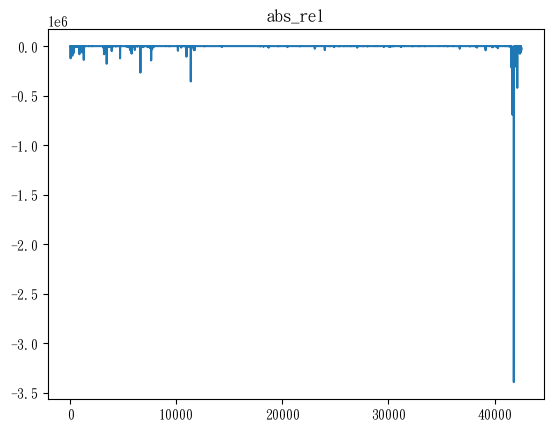

average abs_rel_s: -1270.237625260151


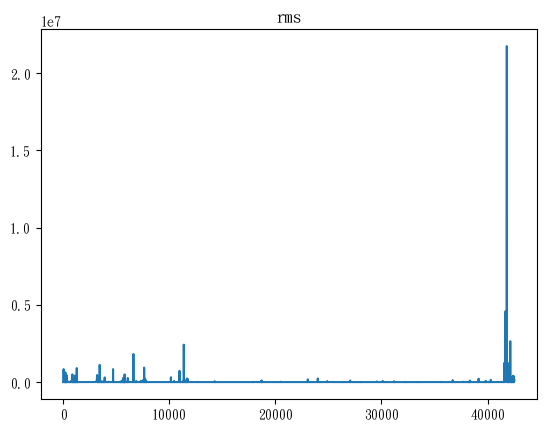

average rms_s: 2598.789854116204


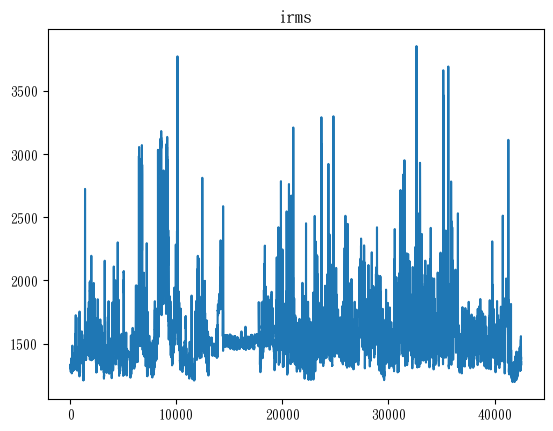

average irms_s: 1546.2836732519343


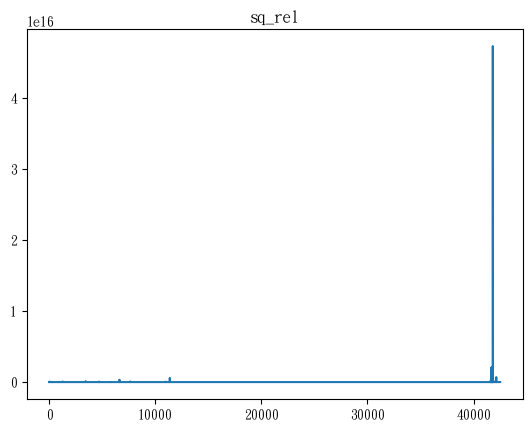

average sq_rel_s: 1264582711994.4485


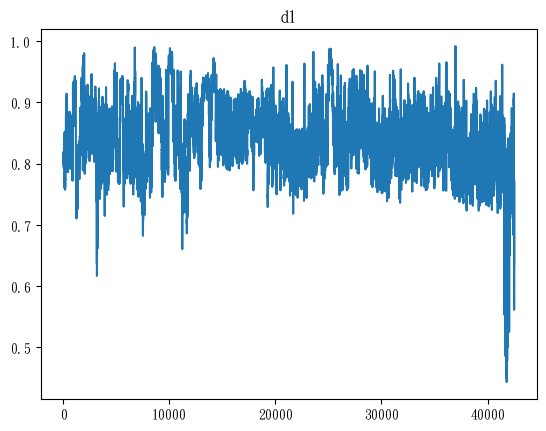

average d1_s: 0.8379552149239882


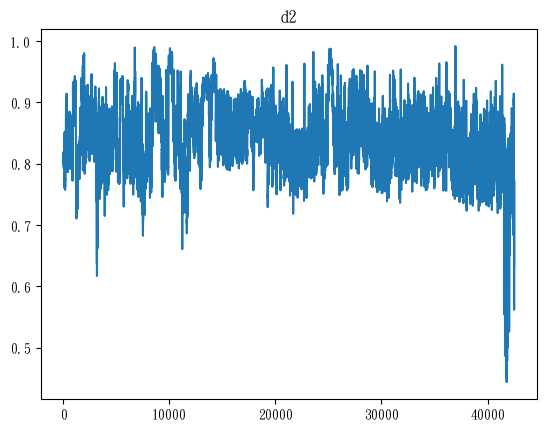

average d2_s: 0.8379602216403429


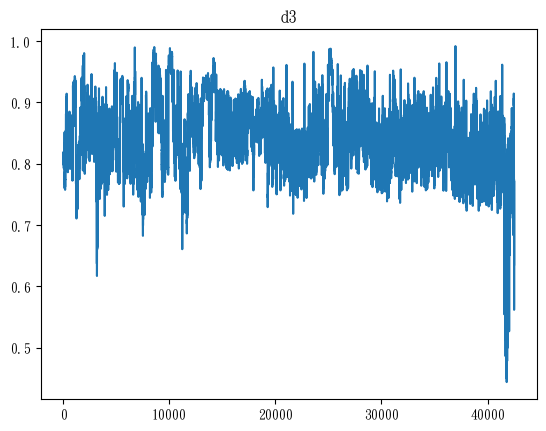

average d3_s: 0.8379672246139616


In [88]:
from statistics import mean
plt.title("abs_rel")
plt.plot(abs_rel_s)
plt.show()
print(f"average abs_rel_s: {mean(abs_rel_s)}")
plt.title("rms")
plt.plot(rms_s)
plt.show()
print(f"average rms_s: {mean(rms_s)}")
plt.title("irms")
plt.plot(irms_s)
plt.show()
print(f"average irms_s: {mean(irms_s)}")
plt.title("sq_rel")
plt.plot(sq_rel_s)
plt.show()
print(f"average sq_rel_s: {mean(sq_rel_s)}")
plt.title("d1")
plt.plot(d1_s)
plt.show()
print(f"average d1_s: {mean(d1_s)}")
plt.title("d2")
plt.plot(d2_s)
plt.show()
print(f"average d2_s: {mean(d2_s)}")
plt.title("d3")
plt.plot(d3_s)
plt.show()
print(f"average d3_s: {mean(d3_s)}")
# print(abs_rel_s)
# print(rms_s)
# print(irms_s)
# print(sq_rel_s)
# print(d1_s)
# print(d2_s)
# print(d3_s)

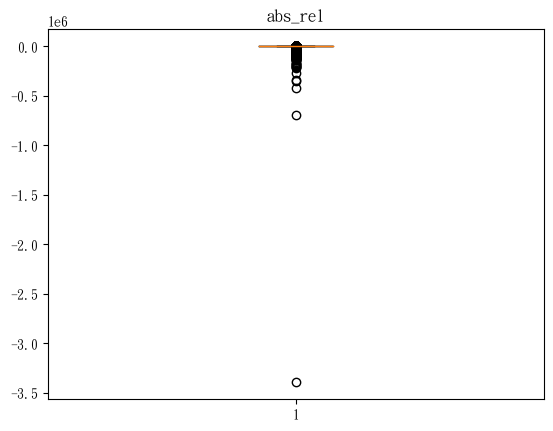

median abs_rel_s: -327.908480941466


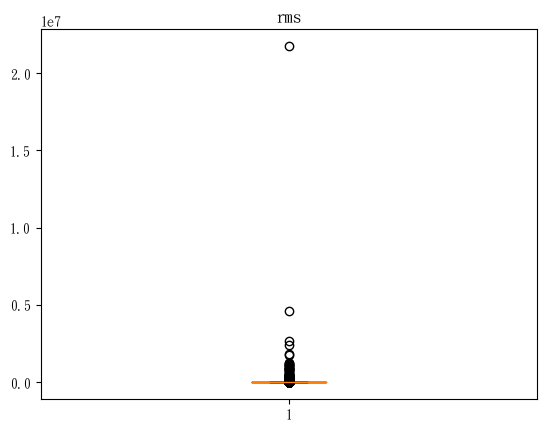

median rms_s: 8.208072291439578


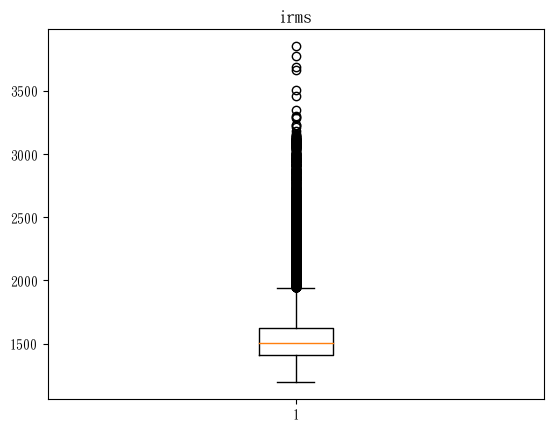

median irms_s: 1500.2661147763192


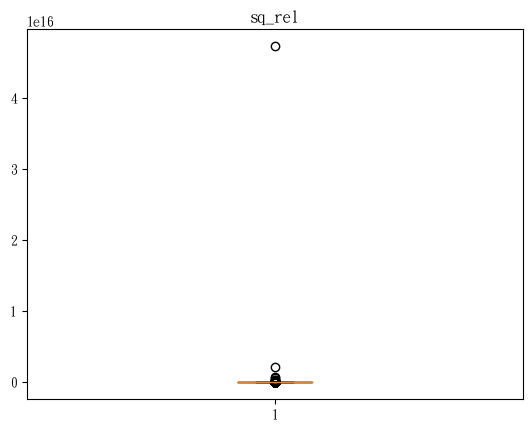

median sq_rel_s: 2524.182204532357


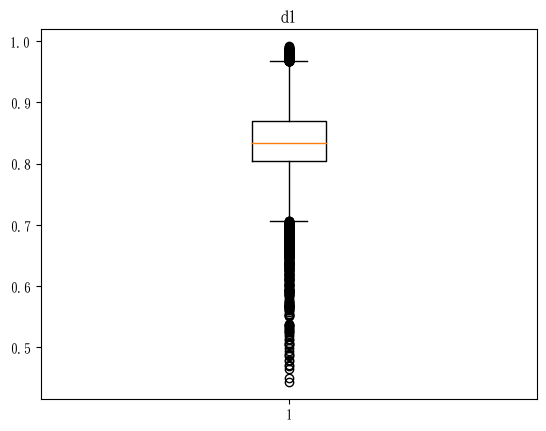

median d1_s: 0.8341173470262486


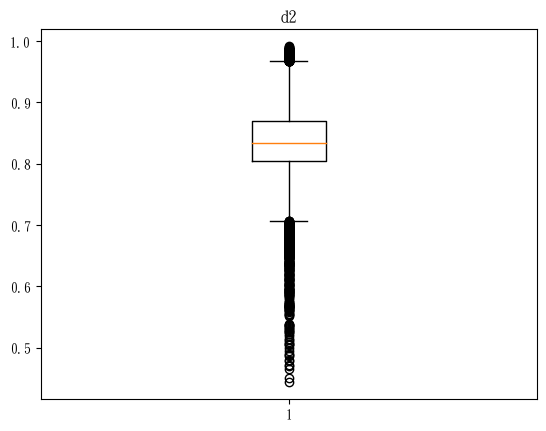

median d2_s: 0.8341173470262486


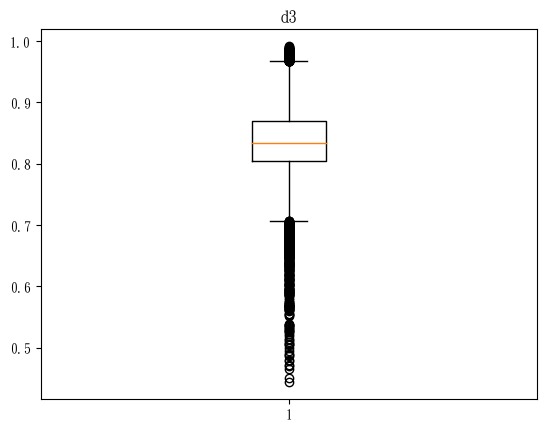

median d3_s: 0.8341436255159664


In [89]:
from statistics import median
plt.title("abs_rel")
plt.boxplot(abs_rel_s)
plt.show()
print(f"median abs_rel_s: {median(abs_rel_s)}")
plt.title("rms")
plt.boxplot(rms_s)
plt.show()
print(f"median rms_s: {median(rms_s)}")
plt.title("irms")
plt.boxplot(irms_s)
plt.show()
print(f"median irms_s: {median(irms_s)}")
plt.title("sq_rel")
plt.boxplot(sq_rel_s)
plt.show()
print(f"median sq_rel_s: {median(sq_rel_s)}")
plt.title("d1")
plt.boxplot(d1_s)
plt.show()
print(f"median d1_s: {median(d1_s)}")
plt.title("d2")
plt.boxplot(d2_s)
plt.show()
print(f"median d2_s: {median(d2_s)}")
plt.title("d3")
plt.boxplot(d3_s)
plt.show()
print(f"median d3_s: {median(d3_s)}")

In [104]:
max_rms_index=rms_s.index(max(rms_s))
print(max_rms_index)
flow_pre_compute_paths[max_rms_index]

41821


WindowsPath('E:/ck/master/ff_depth/flow_pre_compute/2011_10_03_drive_0042_sync/0000000470.pt')

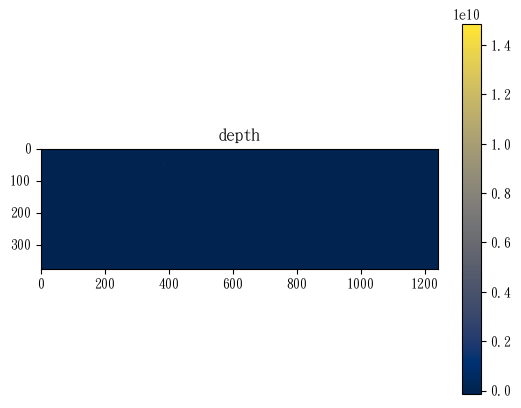

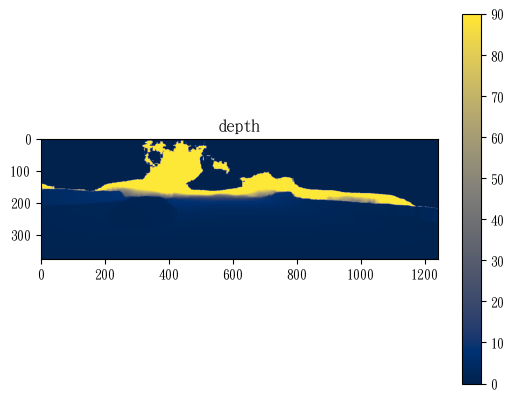

In [128]:
# 繪製深度圖
def plt_depth_map(depth_map: np.ndarray, title="depth"):
    plt.title(title)
    plt.imshow(depth_map[:, :, 2], cmap='cividis')
    plt.colorbar()
    plt.show()
def get_predict_depth(flow_path):
    flow_path = Path(flow_path)
    flow = torch.load(flow_path)
    disparityimg = np.squeeze(np.delete(np.array(flow), 1, axis=2))
    _3d_map = cv2.reprojectImageTo3D(
        disparityimg, get_KITTI_Q_matrix(flow_path.parts[5][:10]))
    predict_depth = torch.from_numpy(_3d_map[:, :, 2])
    depth_path = Path(r"E:\datasets\KITTI_Depth Prediction\data_depth_annotated\train")/flow_path.parts[5]/"proj_depth"/"groundtruth"/"image_02"/(flow_path.stem+".png")
    depth = depth_read(depth_path)
    return _3d_map


test_flow_path=flow_pre_compute_paths[max_rms_index]
test_predict_depth = get_predict_depth(test_flow_path)
plt_depth_map(test_predict_depth)
test_predict_depth = get_predict_depth(test_flow_path)
test_predict_depth[(test_predict_depth<0)]=0
test_predict_depth[(test_predict_depth > 90)] = 90
plt_depth_map(test_predict_depth)
# print(get_predict_depth(flow_pre_compute_paths[max_rms_index]))

In [129]:
test_depth_path = Path(r"E:\datasets\KITTI_Depth Prediction\data_depth_annotated\train") / \
    test_flow_path.parts[5] / "proj_depth" / "groundtruth" / \
    "image_02" / (test_flow_path.stem + ".png")
test_depth=depth_read(test_depth_path)
print(compute_errors_kb(np.array(test_depth), np.array(test_predict_depth[:, :, 2])))
print(f"original:")
print([silog_s[max_rms_index], abs_rel_s[max_rms_index], log10_s[max_rms_index], rms_s[max_rms_index], irms_s[max_rms_index],
      sq_rel_s[max_rms_index], log_rms_s[max_rms_index], d1_s[max_rms_index], d2_s[max_rms_index], d3_s[max_rms_index]])

[nan, -1161.3881612994155, nan, 30.03573189258392, 61025230.87246022, 88364.31992289555, nan, 0.8988397311708128, 0.8988568758893822, 0.8989083100450906]
original:
[nan, -3391422.2910951627, nan, 21749059.521833193, 1314.7696512963635, 4.730215900842246e+16, nan, 0.5264392991239049, 0.5264564438424744, 0.5265078779981827]


C:\Users\ck\AppData\Local\Temp\ipykernel_11980\1273458925.py:2: RuntimeWarning: divide by zero encountered in divide
  thresh = np.maximum((gt / pred), (pred / gt))
C:\Users\ck\AppData\Local\Temp\ipykernel_11980\1273458925.py:16: RuntimeWarning: invalid value encountered in log
  log_rms = (np.log(gt) - np.log(pred)) ** 2
C:\Users\ck\AppData\Local\Temp\ipykernel_11980\1273458925.py:16: RuntimeWarning: divide by zero encountered in log
  log_rms = (np.log(gt) - np.log(pred)) ** 2
C:\Users\ck\AppData\Local\Temp\ipykernel_11980\1273458925.py:22: RuntimeWarning: divide by zero encountered in log
  err = np.log(pred) - np.log(gt)
C:\Users\ck\AppData\Local\Temp\ipykernel_11980\1273458925.py:22: RuntimeWarning: invalid value encountered in log
  err = np.log(pred) - np.log(gt)
C:\Users\ck\AppData\Local\Temp\ipykernel_11980\1273458925.py:25: RuntimeWarning: divide by zero encountered in log10
  err = np.abs(np.log10(pred) - np.log10(gt))
C:\Users\ck\AppData\Local\Temp\ipykernel_11980\127345892